<a href="https://colab.research.google.com/github/yasohasakii/binary_categorical/blob/test-output/resnet_binary_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# git clone repository
!git clone https://github.com/yasohasakii/binary_categorical.git
!mv ./binary_categorical/* ./
!rm -r ./binary_categorical ./sample_data
!pip install tensorflow-gpu
!nvidia-smi

Cloning into 'binary_categorical'...
remote: Enumerating objects: 22669, done.
remote: Counting objects: 100% (22669/22669), done.
remote: Compressing objects: 100% (22659/22659), done.
remote: Total 22669 (delta 25), reused 22642 (delta 10), pack-reused 0
Receiving objects: 100% (22669/22669), 957.08 MiB | 36.56 MiB/s, done.
Resolving deltas: 100% (25/25), done.
Checking out files: 100% (22662/22662), done.
     |████████████████████████████████| 377.0MB 68kB/s 
Thu Aug 29 01:36:40 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80    

In [0]:
# import modual
import os, glob, time
import numpy as np
from keras.layers import Input
from keras.models import Model
from keras.preprocessing import image
from keras import regularizers, optimizers
from keras.callbacks import ModelCheckpoint
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, GlobalAveragePooling2D
from keras.applications.resnet50 import ResNet50
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [0]:
# assert parameters
batch_size = 32
EPOCHS=30

train_count = len(glob.glob('./PetImages/train/*/*.jpg'))
valid_count = len(glob.glob('./PetImages/test/*/*.jpg'))

In [0]:
# def build_model
def build_model():
    input = Input(shape = (224,224,3),name="kfb_image")
    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=input) 
    x = base_model.output
    # for layer in base_model.layers:
    #     layer.trainable=False
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l1(1e-4))(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l1(1e-4))(x)
    x = Dropout(0.5)(x)
    prediction = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=prediction)

    model.compile(loss="binary_crossentropy", optimizer=optimizers.Adam(lr=1e-4,decay =1e-6), metrics=["accuracy"])
    return model

In [0]:
# def train
def train(train_count,valid_count):
    train_datagen = image.ImageDataGenerator(
        rescale = 1./255, 
        rotation_range=40,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')
    valid_datagen = image.ImageDataGenerator(
        rescale = 1./255)

    train_generator = train_datagen.flow_from_directory(
        './PetImages/train/',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')
    validation_generator = valid_datagen.flow_from_directory(
        './PetImages/test',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')

    model = build_model()
    models_save_path = "./models"
    if not os.path.exists(models_save_path):
        os.makedirs(models_save_path)

    checkpoint = ModelCheckpoint(filepath=os.path.join(models_save_path, 'resnet-{epoch:02d}-{val_acc:.4f}.h5'),
                                 monitor='val_acc',
                                 mode='max',
                                 save_best_only=True,
                                 save_weights_only=True)
    print("Train files: {}, valid files: {}".format(train_count,valid_count))
    print('-----------Start training-----------')
    start = time.time()
    history = model.fit_generator(train_generator,
                        steps_per_epoch=train_count // batch_size,
                        epochs=EPOCHS,
                        initial_epoch=0,
                        validation_data=validation_generator,
                        validation_steps=valid_count // batch_size,
                        callbacks=[checkpoint],
                        use_multiprocessing=False)
    end = time.time()
    print("train finished, cost time = {} hours".format(round((end - start) / 3600.0,3)))
    return history

In [0]:
# def plot modual
def plot_train_history(history):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(20, 10))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig("history.png")

In [0]:
# def test
def test(model_path,image_dir):
    model = build_model()
    model.load_weights(model_path, by_name=True)
    images = glob.glob(image_dir+"/*.jpg")
    preds=0
    for imgs in images:
        im = image.load_img(imgs, target_size=(224, 224))
        im = image.img_to_array(im)* 1. / 255
        im = np.expand_dims(im, axis=0)
        out = round(model.predict(im)[0][0])
        preds += out
    if preds/len(images)>0.5:
        print("{}: dog, mean score{}".format(os.path.basename(image_dir),preds/len(images)))
    else:
        print("{}: cat, mean score{}".format(os.path.basename(image_dir),preds/len(images)))

In [52]:
if __name__=="__main__":
    history = train(train_count,valid_count)

Found 15894 images belonging to 2 classes.
Found 6754 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Train files: 15894, valid files: 6754
-----------Start training-----------
Epoch 1/30


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6553600 bytes but only got 0. Skipping tag 49
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 4951. Skipping tag 51
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293339136 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expect

301/496 [=================>............] - ETA: 3:19 - loss: 1.7183 - acc: 0.8740

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404094976 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404619264 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 425459712 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1385474 bytes but only got 6833. Skipping tag 513
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expe

377/496 [=====================>........] - ETA: 1:58 - loss: 1.6834 - acc: 0.8884

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18350080 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


443/496 [=========================>....] - ETA: 52s - loss: 1.6600 - acc: 0.8972

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 209715200 bytes but only got 0. Skipping tag 48
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 52428800 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6468665344 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 7027. Skipping tag 48
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expe

453/496 [==========================>...] - ETA: 42s - loss: 1.6561 - acc: 0.8986

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262146 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262151 bytes but only got 0. Skipping tag 56
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))


482/496 [============================>.] - ETA: 13s - loss: 1.6480 - acc: 0.9015

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but 

496/496 [==============================] - 546s 1s/step - loss: 1.6442 - acc: 0.9028 - val_loss: 1.5028 - val_acc: 0.9618
Epoch 2/30
496/496 [==============================] - 504s 1s/step - loss: 1.4278 - acc: 0.9580 - val_loss: 1.3618 - val_acc: 0.9591
Epoch 3/30
496/496 [==============================] - 501s 1s/step - loss: 1.2552 - acc: 0.9692 - val_loss: 1.1644 - val_acc: 0.9704
Epoch 4/30
496/496 [==============================] - 506s 1s/step - loss: 1.0807 - acc: 0.9708 - val_loss: 0.9913 - val_acc: 0.9722
Epoch 5/30
338/496 [===================>..........] - ETA: 2:21 - loss: 0.9222 - acc: 0.9733

KeyboardInterrupt: ignored

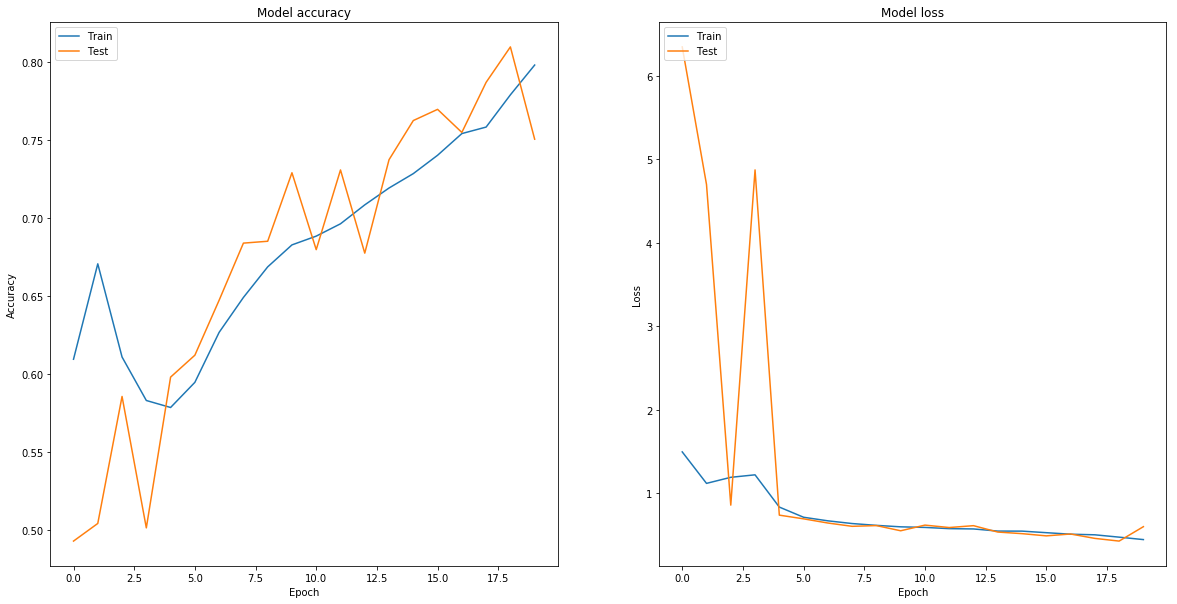

In [27]:
plot_train_history(history)

In [0]:
test('./models/resnet-04-0.9722.h5','./PetImages/test/Cat')
    

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
